Referenced from ChatGPT

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip '/content/drive/MyDrive/lfw.zip'

Streaming output truncated to the last 5000 lines.
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0012.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0012.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep

In [5]:
path = '/content/lfw'

In [6]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataloader = DataLoader(ImageFolder(path, transform=transform), batch_size=20, shuffle=True)



This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device available. Using GPU.")
else:
    print("CUDA device not available. Using CPU.")


CUDA device available. Using GPU.


torch.Size([256, 256, 3])


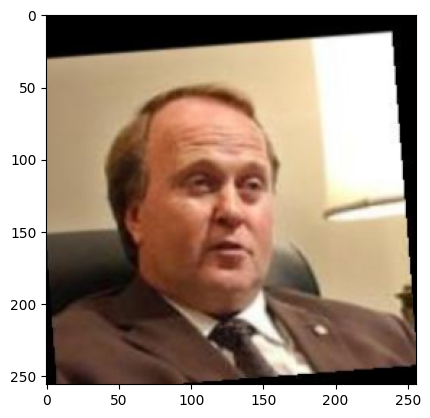

In [8]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

the differences between AutoEncoders (AEs) and Variational AutoEncoders (VAEs) is crucial, as it informs how you might adapt an AE to a VAE. The differences span across their applications, architecture, and loss functions:

# Applications
**AutoEncoders:**
Data Compression: AEs are primarily used for data compression where the data is reduced to a lower-dimensional space (latent space) and then reconstructed back.
Denoising: They are also widely used for denoising tasks, where they learn to reconstruct the original, clean data from corrupted inputs.
Feature Learning: AEs can be used for unsupervised feature learning, serving as a precursor to other learning tasks.

**Variational AutoEncoders:**
Data Generation: VAEs are generative models used to create new data samples that are similar to the training data. This makes them suitable for tasks like image generation, music creation, etc.

**Representation Learning:** VAEs are used for learning complex probability distributions of data and can be used to explore the data manifold.

**Semi-supervised Learning:** Their probabilistic nature allows for more flexible applications in semi-supervised learning scenarios.

# Architecture

**AutoEncoders:**
Structure: A typical AE consists of an encoder that compresses the input into a latent representation and a decoder that reconstructs the input from this representation.
Deterministic: The process of encoding and decoding is deterministic, meaning the same input will always produce the same encoded representation.

**Variational AutoEncoders:**
Probabilistic Approach: VAEs introduce a probabilistic approach to the encoding process. Instead of encoding an input as a single point, they encode it as a distribution over the latent space.

**Reparameterization Trick:** VAEs use the reparameterization trick to sample from the latent space distribution, which is crucial for backpropagation during training.

# Loss Function

**AutoEncoders:**
Loss Function: The loss function in AEs is typically a reconstruction loss, such as mean squared error (MSE) or binary cross-entropy, which measures the difference between the input and its reconstruction.

**Variational AutoEncoders:**
Reconstruction + Regularization: VAEs also use a reconstruction loss, but in addition, they include a regularization term - the Kullback-Leibler (KL) divergence. This term penalizes the model if the learned distributions in the latent space diverge significantly from a prior distribution, typically a standard normal distribution.

**Balanced Objective:** The overall loss function of a VAE balances between accurate reconstruction and maintaining a regularized latent space. This balance is critical for the generative properties of VAEs.

In summary, while both AEs and VAEs involve encoding inputs into a compressed latent space and then reconstructing the output from this space, VAEs introduce a probabilistic approach and a more complex loss function. These differences enable VAEs to not only reconstruct inputs but also generate new data that is similar to the original dataset, making them more versatile for generative tasks.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE1(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE1, self).__init__()

        # Encoder layers
        self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(16)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(32)
        self.enc_conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(64)

        # Latent space layers
        self.fc_mu = nn.Linear(64 * 32 * 32, latent_dim)
        self.fc_logvar = nn.Linear(64 * 32 * 32, latent_dim)

        # Decoder layers
        self.dec_fc = nn.Linear(latent_dim, 64 * 32 * 32)
        self.dec_bn1 = nn.BatchNorm1d(64 * 32 * 32)
        self.dec_unflatten = nn.Unflatten(1, (64, 32, 32))
        self.dec_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_conv2 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        self.dec_bn3 = nn.BatchNorm2d(16)
        self.dec_conv3 = nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1)


    def encoder(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decoder(self, z):
        x = F.relu(self.dec_fc(z))
        x = self.dec_unflatten(x)
        x = F.relu(self.dec_conv1(x))
        x = F.relu(self.dec_conv2(x))
        x = torch.sigmoid(self.dec_conv3(x))
        return x

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar


Encoder

The encoder part of the VAE is responsible for compressing the input data into a latent space representation. In your model:

Convolutional Layers (enc_conv1, enc_conv2, enc_conv3):

These layers progressively downsample the input image. They apply convolution operations to extract features from the input. The use of strides reduces the spatial dimensions of the feature maps, effectively compressing the data.
Batch Normalization Layers (enc_bn1, enc_bn2, enc_bn3): These layers normalize the output of the convolutional layers, stabilizing and speeding up training.
Latent Space Representation (fc_mu, fc_logvar): After flattening the output of the last convolutional layer, two fully connected layers (fc_mu and fc_logvar) compute the mean (mu) and log-variance (logvar) of the latent space distribution for each input. These parameters define a Gaussian distribution for each data point in the latent space.
Decoder
The decoder reconstructs data from the latent space back to the original input space:

Fully Connected Layer (dec_fc):

This layer takes a latent space vector and transforms it into a higher-dimensional space, preparing it for deconvolution.
Batch Normalization and Unflatten (dec_bn1, dec_unflatten): The batch normalization normalizes the output, and the unflatten operation reshapes the vector into a multi-dimensional tensor suitable for deconvolution.


Transposed Convolutional Layers (dec_conv1, dec_conv2, dec_conv3):

These layers perform the opposite operation of convolutional layers, upsampling the feature maps to reconstruct the original input dimensions. The final layer uses a sigmoid activation to ensure the output values are in the same range as the input (typically [0, 1] for images).

Reparameterization Trick (reparameterize)

This function implements the reparameterization trick, a critical aspect of VAEs. It allows the model to backpropagate through random sampling by reparameterizing the latent space distribution in terms of its mean and standard deviation. It makes the sampling process differentiable, which is essential for training the model using gradient descent.

Forward Pass (forward)

The forward method defines the data flow through the VAE:

The input data x is passed through the encoder to obtain the mean (mu) and log-variance (logvar) of the latent distribution.
The reparameterize method uses these to generate a latent vector z.
The decoder then takes z and reconstructs the input data recon_x.

Overall, VAE1 is a complete implementation of a VAE, with a clear distinction between the encoder and decoder components and the correct application of the reparameterization trick. This model can be used for tasks like unsupervised learning of complex data distributions, data compression, and generative tasks, particularly in contexts where the input data is image-based.

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [11]:

# Instantiate the VAE model
model = VAE1()

# Move model to appropriate device (GPU or CPU)
device = torch.device("cuda")
model.to(device)


images, _ = next(iter(dataloader))
image = images[0].unsqueeze(0).to(device)  # Take the first image and add batch dimension

reconstructed_image, mu, logvar = model(image)

# Print the shape of the outputs
print("Shape of mu:", mu.shape)  # Latent space mean
print("Shape of logvar:", logvar.shape)  # Latent space log variance
print("Shape of reconstructed image:", reconstructed_image.shape)

# Generating new samples in the latent space
# To generate new samples, we sample from the distribution defined by mu and logvar
# and pass it through the decoder. This is the essence of the VAE's generative capability.

# Sample from the latent space
std = torch.exp(0.5 * logvar)
eps = torch.randn_like(std)
z = mu + eps * std  # Reparameterization trick

# Generate a new image from the sampled latent vector
generated_image = model.decoder(z)

# Print the shape of the generated image
print("Shape of generated image:", generated_image.shape)


Shape of mu: torch.Size([1, 128])
Shape of logvar: torch.Size([1, 128])
Shape of reconstructed image: torch.Size([1, 3, 256, 256])
Shape of generated image: torch.Size([1, 3, 256, 256])


# Latent Space in VAEs
Latent Space Representation: In a VAE, the latent space is a compressed representation of the input data. This space is not just a random compression; it's structured in a way that similar data points in the input space (like similar images) are mapped close to each other in the latent space. The VAE learns this mapping during training.
Probabilistic Nature of VAEs: Unlike traditional autoencoders, VAEs are probabilistic. The encoder of a VAE maps input data to a distribution in the latent space, typically a Gaussian distribution. This is done by learning two things for each data point: a mean (μ) and a variance (σ²). These parameters define the Gaussian distribution for each data point in the latent space.

# Generating New Samples Sampling from the Latent Space:
To generate new samples, we randomly sample points from the latent space. Since the VAE is trained to model the latent space as from a standard Gaussian distribution. This random sampling is what allows the VAE to generate new data points that were never seen during training, yet are similar to the training data.

**Reparameterization Trick:**
An important aspect of VAEs is the reparameterization trick. Normally, sampling from a distribution, as required in the VAE, would be a stochastic process and not differentiable, which poses a problem for backpropagation. The reparameterization trick gets around this by expressing the random sample in terms of the learned mean (μ) and variance (σ²), plus a random component from a standard normal distribution. Specifically, a sample z from the latent space is obtained using the formula: z = μ + σ * ε, where ε is drawn from a standard normal distribution. This allows the model to backpropagate through the random sampling process.

**Decoding to Generate New Data:** Once we have a sample z from the latent space, we pass it through the decoder of the VAE. The decoder's job is to map this point back to the original data space. In doing so, it essentially "imagines" what kind of input data could have resulted in such a point in the latent space, thereby generating a new data point that is similar to the training data but not an exact replica.

**Diversity of Generated Samples:** Because the sampling in the latent space is random, each sample is likely to be different, leading to a variety of generated data points. The quality and diversity of these generated samples depend on how well the VAE has learned the data distribution and structured the latent space.

# Practical Implications
**Interpolation:** Since similar data points map to nearby points in the latent space, interpolating between two points in the latent space can create a smooth transition in the generated data. For instance, in the context of image data, this might mean morphing one image into another.

**Control and Variation:** By controlling the sampling process or manipulating the latent variables, we can influence the characteristics of the generated data. This is especially useful in creative applications like generating art or designing new products.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


In [12]:
# Counting the total number of parameters in the VAE model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_params)


Total number of trainable parameters: 25428371


Printing the Total Number of Parameters in the Model
The total number of parameters in a model provides insight into its complexity. In PyTorch, you can calculate this by summing the number of elements in each parameter tensor:This code iterates over all parameters of the VAE that require gradients (i.e., trainable parameters) and sums up their total number. The numel() function returns the number of elements in a tensor, thus giving a count of parameters per layer.

* create an optimizer for training

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
def vae_loss(reconstructed_x, original_x, mu, logvar):
    # Reconstruction loss (MSE or BCE)
    reconstruction_loss = F.mse_loss(reconstructed_x, original_x, reduction='sum')

    # KL divergence
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reconstruction_loss + kl_divergence



#Loss Function in VAEs
The loss function of a VAE is crucial, as it encapsulates two primary objectives of the model: reconstruction accuracy and effective latent space regularization. It typically consists of two terms:

**Reconstruction Loss:** This term measures how well the decoded outputs of the VAE match the original inputs. It encourages the decoder to accurately reconstruct the input data from the latent representations. This is critical for ensuring that the latent space retains as much information about the input data as possible.
In the case of image data, a common choice for this term is the Binary Cross-Entropy (BCE) loss. This loss computes the pixel-wise difference between the original image and its reconstruction, ideal for images with values normalized between 0 and 1.
For other types of data, mean squared error (MSE) or other relevant loss functions could be used.

**KL Divergence:** The Kullback-Leibler (KL) divergence term is a measure from information theory that quantifies how much one probability distribution (the one learned by the encoder) diverges from another reference distribution (typically a standard normal distribution).
In VAEs, this term acts as a regularizer for the latent space. It encourages the distributions learned for the latent representations to be close to a standard normal distribution. This regularization ensures that the latent space does not overfit to the training data and allows for effective sampling and generation of new data points.
Mathematically, it penalizes the model if the learned distribution (characterized by its mean and variance) deviates significantly from a standard normal distribution.

The combination of these two terms balances the VAE’s dual objectives: accurately reconstructing data (through the reconstruction loss) and ensuring a well-structured, regularized latent space (through the KL divergence). This balance is crucial for the generative capabilities of VAEs. Too much emphasis on reconstruction can lead to overfitting and poor generation quality, while too much emphasis on the KL term can lead to underfitting and loss of meaningful structure in the latent space.

In essence, the loss function of a VAE encapsulates the model's essence - learning a compressed but meaningful representation of the data that is not just a rote memorization but a genuine understanding that can be used to generate new, realistic data points.

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [15]:
# Number of epochs to train the model
num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)

        # Forward pass
        reconstructed_images, mu, logvar = model(images)

        # Calculate loss
        loss = vae_loss(reconstructed_images, images, mu, logvar)

        # Backward pass and optimize
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()        # Calculate gradients
        optimizer.step()       # Update parameters

        total_loss += loss.item()

    # Calculate average loss over the epoch
    avg_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 6162.9390
Epoch [2/20], Loss: 3400.9769
Epoch [3/20], Loss: 2731.5745
Epoch [4/20], Loss: 2449.4939
Epoch [5/20], Loss: 2277.6993
Epoch [6/20], Loss: 2177.4690
Epoch [7/20], Loss: 2090.6635
Epoch [8/20], Loss: 2014.1419
Epoch [9/20], Loss: 1956.4675
Epoch [10/20], Loss: 1890.5812
Epoch [11/20], Loss: 1846.3605
Epoch [12/20], Loss: 1799.6681
Epoch [13/20], Loss: 1757.3687
Epoch [14/20], Loss: 1723.3222
Epoch [15/20], Loss: 1687.5027
Epoch [16/20], Loss: 1654.4075
Epoch [17/20], Loss: 1625.6356
Epoch [18/20], Loss: 1601.9741
Epoch [19/20], Loss: 1588.2641
Epoch [20/20], Loss: 1561.4285


# Troubleshooting Non-Decreasing Loss
If you observe that the loss is not decreasing over epochs, consider the following troubleshooting steps:

Learning Rate: Check if the learning rate is appropriately set. Too high a learning rate can cause the model to overshoot minima, while too low a rate might make the learning process extremely slow.

Model Architecture: Revisit your model's architecture. Ensure that the model is neither too simple (underfitting) nor too complex (overfitting).

Data Preprocessing: Ensure that the data is correctly preprocessed. For instance, image data should typically be normalized.

Loss Function: Verify the implementation of your loss function. Ensure that both reconstruction loss and KL divergence are correctly computed and combined.

Batch Size: Experiment with different batch sizes. Sometimes, smaller or larger batch sizes can significantly impact model performance.

Optimizer: Experiment with different optimizers or optimizer settings. Different optimizers might yield better results.

Regularization: Add regularization techniques if your model is overfitting.

Initialization: Try different weight initialization strategies. Proper initialization can sometimes improve training.

Data Quality and Variety: Ensure that your dataset is of good quality and representative of the problem domain.
Early Stopping: Implement early stopping to prevent overfitting if the loss starts increasing after decreasing initially.


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

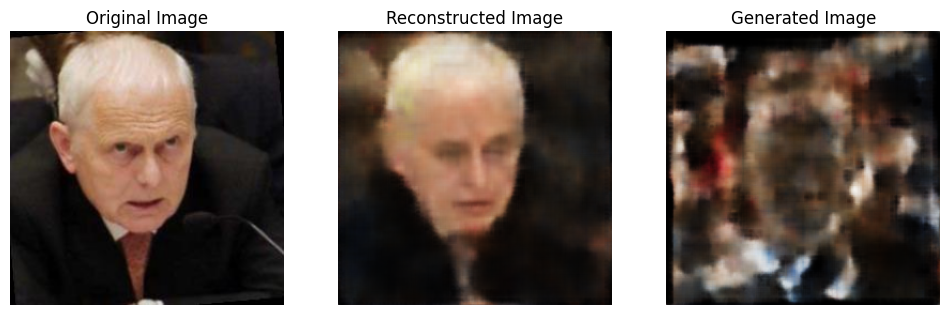

In [18]:
import matplotlib.pyplot as plt

# Select a random image from the dataset
images, _ = next(iter(dataloader))
original_image = images[0].unsqueeze(0).to(device)  # Adding a batch dimension


# Forward pass through the model to get the reconstructed image
reconstructed_image, _, _ = model(original_image)

# Assuming the latent space size is 128
latent_size = 128
random_z = torch.randn(1, latent_size).to(device)  # Generate a random latent vector with the correct size

# Decode the random latent vector to generate a new image
generated_image = model.decoder(random_z)


# Convert the tensors to numpy for visualization
# Detach and move to CPU for converting to numpy
original_image_np = original_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
reconstructed_image_np = reconstructed_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
generated_image_np = generated_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(original_image_np)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed_image_np)
plt.title('Reconstructed Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(generated_image_np)
plt.title('Generated Image')
plt.axis('off')

plt.show()
